In [1]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import os, sys, glob, string, argparse
from climsim_utils.data_utils import *

In [2]:
grid_info = xr.open_dataset('/global/cfs/cdirs/m4334/jerry/climsim3_dev/grid_info/ClimSim_low-res_grid-info.nc')
input_mean = xr.open_dataset('/global/cfs/cdirs/m4334/jerry/climsim3_dev/preprocessing/normalizations/inputs/input_mean_v2_rh_mc_pervar.nc')
input_max = xr.open_dataset('/global/cfs/cdirs/m4334/jerry/climsim3_dev/preprocessing/normalizations/inputs/input_max_v2_rh_mc_pervar.nc')
input_min = xr.open_dataset('/global/cfs/cdirs/m4334/jerry/climsim3_dev/preprocessing/normalizations/inputs/input_min_v2_rh_mc_pervar.nc')
output_scale = xr.open_dataset('/global/cfs/cdirs/m4334/jerry/climsim3_dev/preprocessing/normalizations/outputs/output_scale_std_lowerthred_v6.nc')
lbd_qn = np.loadtxt('/global/cfs/cdirs/m4334/jerry/climsim3_dev/preprocessing/normalizations/inputs/qn_exp_lambda_large.txt', delimiter = ',')

data = data_utils(grid_info = grid_info,
                input_mean = input_mean, 
                input_max = input_max, 
                input_min = input_min, 
                output_scale = output_scale,
                qinput_log = False,
                normalize = False)
data.set_to_v6_vars()

lat = grid_info['lat'].values
lon = grid_info['lon'].values
lon = grid_info['lon'].values
lon = ((lon + 180) % 360) - 180
level = grid_info.lev.values
lat_bin_mids = data.lat_bin_mids

color_dict = {
    'unet': 'green',
    'squeezeformer': 'purple',
    'pure_resLSTM': 'blue',
    'pao_model': 'red',
    'convnext': 'gold',
    'encdec_lstm': 'orange',
}

label_dict = {
    'unet': 'U-Net',
    'squeezeformer': 'Squeezeformer',
    'pure_resLSTM': 'Pure ResLSTM',
    'pao_model': 'Pao Model',
    'convnext': 'ConvNeXt',
    'encdec_lstm': 'Encoder-Decoder LSTM',
}

# retrieve precomputed 1-year tropopause level distribution (we used as a microphysics constraint)
idx_p400_t10 = np.load('/pscratch/sd/z/zeyuanhu/hu_etal2024_data/microphysics_hourly/first_true_indices_p400_t10.npy')
for i in range(idx_p400_t10.shape[0]):
    for j in range(idx_p400_t10.shape[1]):
        idx_p400_t10[i,j] = level[int(idx_p400_t10[i,j])]

idx_p400_t10 = idx_p400_t10.mean(axis=0)
idx_p400_t10 = idx_p400_t10[np.newaxis,:]

idx_tropopause_zm = data.zonal_bin_weight_2d(idx_p400_t10)

def area_mean(ds, var):
    arr = ds[var].values
    arr_reshaped = np.transpose(arr, (0,2,1))
    arr_zonal_mean = data.zonal_bin_weight_3d(arr_reshaped)
    return arr_zonal_mean

def zonal_diff(ds_sp, ds_nn, var):
    diff_zonal_mean = (area_mean(ds_nn, var) - area_mean(ds_sp, var)).mean(axis = 0)
    diff_zonal = xr.DataArray(diff_zonal_mean.T, dims = ['level', 'lat'], coords = {'level':level, 'lat': lat_bin_mids})
    return diff_zonal

def get_dp(ds):
    ps = ds['PS']
    p_interface = (ds['hyai'] * ds['P0'] + ds['hybi'] * ds['PS']).values
    if p_interface.shape[0] == 61:
        p_interface = np.swapaxes(p_interface, 0, 1)
    dp = p_interface[:,1:61,:] - p_interface[:,0:60,:]
    return dp

def get_tcp_mean(ds, area_weight):
    cld = (ds['CLDICE'][:,:,:] + ds['CLDLIQ'][:,:,:]).values
    dp = get_dp(ds)
    tcp = np.sum(cld*dp, axis = 1)/9.81
    tcp_mean = np.average(tcp, weights = area_weight, axis = 1)
    return tcp_mean

grid_area = grid_info['area'].values
lev = grid_info['lev'].values
area_weight = grid_area/np.sum(grid_area)

ds_sp_1 = xr.open_mfdataset('/pscratch/sd/z/zeyuanhu/hu_etal2024_data_v2/data/h0/5year/mmf_ref/control_fullysp_jan_wmlio_r3.eam.h0.000[34567]*.nc')
ds_sp_2 = xr.open_mfdataset('/pscratch/sd/z/zeyuanhu/hu_etal2024_data_v2/data/h0/5year/mmf_b/control_fullysp_jan_wmlio_r3_b.eam.h0.000[34567]*.nc')

ds_sp_1['DQnPHYS'] = ds_sp_1['DQ2PHYS'] + ds_sp_1['DQ3PHYS']
ds_sp_2['DQnPHYS'] = ds_sp_2['DQ2PHYS'] + ds_sp_2['DQ3PHYS']

sp_dp = get_dp(ds_sp_1)
total_weight = sp_dp * area_weight[None, None, :]
total_weight = total_weight.mean(axis = 0)
total_weight = total_weight/total_weight.sum()

In [3]:
standard_path = '/pscratch/sd/j/jerrylin/hugging/E3SM-MMF_ne4/online_runs/climsim3_ensembles_good/standard/five_year_runs/deprecated/'

ds_unet_seed_7 = xr.open_mfdataset(os.path.join(standard_path, 'unet_seed_7/run/unet_seed_7.eam.h0.000[34567]*.nc'))
ds_unet_seed_43 = xr.open_mfdataset(os.path.join(standard_path, 'unet_seed_43/run/unet_seed_43.eam.h0.000[34567]*.nc'))
ds_unet_seed_1024 = xr.open_mfdataset(os.path.join(standard_path, 'unet_seed_1024/run/unet_seed_1024.eam.h0.000[34567]*.nc'))

ds_unet_seed_7['DQnPHYS'] = ds_unet_seed_7['DQ2PHYS'] + ds_unet_seed_7['DQ3PHYS']
ds_unet_seed_43['DQnPHYS'] = ds_unet_seed_43['DQ2PHYS'] + ds_unet_seed_43['DQ3PHYS']
ds_unet_seed_1024['DQnPHYS'] = ds_unet_seed_1024['DQ2PHYS'] + ds_unet_seed_1024['DQ3PHYS']

ds_squeezeformer_seed_7 = xr.open_mfdataset(os.path.join(standard_path, 'squeezeformer_seed_7/run/squeezeformer_seed_7.eam.h0.000[34567]*.nc'))
ds_squeezeformer_seed_43 = xr.open_mfdataset(os.path.join(standard_path, 'squeezeformer_seed_43/run/squeezeformer_seed_43.eam.h0.000[34567]*.nc'))
ds_squeezeformer_seed_1024 = xr.open_mfdataset(os.path.join(standard_path, 'squeezeformer_seed_1024/run/squeezeformer_seed_1024.eam.h0.000[34567]*.nc'))

ds_squeezeformer_seed_7['DQnPHYS'] = ds_squeezeformer_seed_7['DQ2PHYS'] + ds_squeezeformer_seed_7['DQ3PHYS']
ds_squeezeformer_seed_43['DQnPHYS'] = ds_squeezeformer_seed_43['DQ2PHYS'] + ds_squeezeformer_seed_43['DQ3PHYS']
ds_squeezeformer_seed_1024['DQnPHYS'] = ds_squeezeformer_seed_1024['DQ2PHYS'] + ds_squeezeformer_seed_1024['DQ3PHYS']

ds_pure_resLSTM_seed_7 = xr.open_mfdataset(os.path.join(standard_path, 'pure_resLSTM_seed_7/run/pure_resLSTM_seed_7.eam.h0.000[34567]*.nc'))
ds_pure_resLSTM_seed_43 = xr.open_mfdataset(os.path.join(standard_path, 'pure_resLSTM_seed_43/run/pure_resLSTM_seed_43.eam.h0.000[34567]*.nc'))
ds_pure_resLSTM_seed_1024 = xr.open_mfdataset(os.path.join(standard_path, 'pure_resLSTM_seed_1024/run/pure_resLSTM_seed_1024.eam.h0.000[34567]*.nc'))

ds_pure_resLSTM_seed_7['DQnPHYS'] = ds_pure_resLSTM_seed_7['DQ2PHYS'] + ds_pure_resLSTM_seed_7['DQ3PHYS']
ds_pure_resLSTM_seed_43['DQnPHYS'] = ds_pure_resLSTM_seed_43['DQ2PHYS'] + ds_pure_resLSTM_seed_43['DQ3PHYS']
ds_pure_resLSTM_seed_1024['DQnPHYS'] = ds_pure_resLSTM_seed_1024['DQ2PHYS'] + ds_pure_resLSTM_seed_1024['DQ3PHYS']

ds_pao_model_seed_7 = xr.open_mfdataset(os.path.join(standard_path, 'pao_model_seed_7/run/pao_model_seed_7.eam.h0.000[34567]*.nc'))
ds_pao_model_seed_43 = xr.open_mfdataset(os.path.join(standard_path, 'pao_model_seed_43/run/pao_model_seed_43.eam.h0.000[34567]*.nc'))
ds_pao_model_seed_1024 = xr.open_mfdataset(os.path.join(standard_path, 'pao_model_seed_1024/run/pao_model_seed_1024.eam.h0.000[34567]*.nc'))

ds_pao_model_seed_7['DQnPHYS'] = ds_pao_model_seed_7['DQ2PHYS'] + ds_pao_model_seed_7['DQ3PHYS']
ds_pao_model_seed_43['DQnPHYS'] = ds_pao_model_seed_43['DQ2PHYS'] + ds_pao_model_seed_43['DQ3PHYS']
ds_pao_model_seed_1024['DQnPHYS'] = ds_pao_model_seed_1024['DQ2PHYS'] + ds_pao_model_seed_1024['DQ3PHYS']

ds_convnext_seed_7 = xr.open_mfdataset(os.path.join(standard_path, 'convnext_seed_7/run/convnext_seed_7.eam.h0.000[34567]*.nc'))
ds_convnext_seed_43 = xr.open_mfdataset(os.path.join(standard_path, 'convnext_seed_43/run/convnext_seed_43.eam.h0.000[34567]*.nc'))
ds_convnext_seed_1024 = xr.open_mfdataset(os.path.join(standard_path, 'convnext_seed_1024/run/convnext_seed_1024.eam.h0.000[34567]*.nc'))

ds_convnext_seed_7['DQnPHYS'] = ds_convnext_seed_7['DQ2PHYS'] + ds_convnext_seed_7['DQ3PHYS']
ds_convnext_seed_43['DQnPHYS'] = ds_convnext_seed_43['DQ2PHYS'] + ds_convnext_seed_43['DQ3PHYS']
ds_convnext_seed_1024['DQnPHYS'] = ds_convnext_seed_1024['DQ2PHYS'] + ds_convnext_seed_1024['DQ3PHYS']

ds_encdec_lstm_seed_7 = xr.open_mfdataset(os.path.join(standard_path, 'encdec_lstm_seed_7/run/encdec_lstm_seed_7.eam.h0.000[34567]*.nc'))
ds_encdec_lstm_seed_43 = xr.open_mfdataset(os.path.join(standard_path, 'encdec_lstm_seed_43/run/encdec_lstm_seed_43.eam.h0.000[34567]*.nc'))
ds_encdec_lstm_seed_1024 = xr.open_mfdataset(os.path.join(standard_path, 'encdec_lstm_seed_1024/run/encdec_lstm_seed_1024.eam.h0.000[34567]*.nc'))

ds_encdec_lstm_seed_7['DQnPHYS'] = ds_encdec_lstm_seed_7['DQ2PHYS'] + ds_encdec_lstm_seed_7['DQ3PHYS']
ds_encdec_lstm_seed_43['DQnPHYS'] = ds_encdec_lstm_seed_43['DQ2PHYS'] + ds_encdec_lstm_seed_43['DQ3PHYS']
ds_encdec_lstm_seed_1024['DQnPHYS'] = ds_encdec_lstm_seed_1024['DQ2PHYS'] + ds_encdec_lstm_seed_1024['DQ3PHYS']

In [4]:
def area_time_mean_3d(ds, var):
    arr = ds[var].values[1:,:,:]
    arr_reshaped = np.transpose(arr, (0,2,1))
    arr_zonal_mean = data.zonal_bin_weight_3d(arr_reshaped)
    arr_zonal_time_mean = arr_zonal_mean.mean(axis = 0)
    arr_zonal_time_mean = xr.DataArray(arr_zonal_time_mean.T, dims = ['hybrid pressure (hPa)', 'latitude'], coords = {'hybrid pressure (hPa)':level, 'latitude': lat_bin_mids})
    return arr_zonal_time_mean

def plot_zonal_mean_bias(var):
    # Create a figure with subplots
    fig, axs = plt.subplots(2, 3, figsize=(14, 6.5), constrained_layout = True) 
    # Generate the panel labels
    labels = [f"({letter})" for letter in string.ascii_lowercase[:6]]
    latitude_ticks = [-60, -30, 0, 30, 60]
    latitude_labels = ['60S', '30S', '0', '30N', '60N']
    # Loop through each variable and its corresponding subplot row
    var_settings = {
        'T': {'var_title': 'T', 'scaling': 1.0, 'unit': 'K', 'vmax': 5, 'vmin': -5},
        'Q': {'var_title': 'Q', 'scaling': 1000.0, 'unit': 'g/kg', 'vmax': 1, 'vmin': -1},
        'U': {'var_title': 'U', 'scaling': 1.0, 'unit': 'm/s', 'vmax': 4, 'vmin': -4},
        'CLDLIQ': {'var_title': 'Liquid Cloud', 'scaling': 1e6, 'unit': 'mg/kg', 'vmax': 40, 'vmin': -40},
        'CLDICE': {'var_title': 'Ice Cloud', 'scaling': 1e6, 'unit': 'mg/kg', 'vmax': 5, 'vmin': -5},
        'DTPHYS': {'var_title': 'dT/dt', 'scaling': 1., 'unit': 'K/s', 'vmax': 1.5e-5, 'vmin': -1.5e-5},
        'DQ1PHYS': {'var_title': 'dQ/dt', 'scaling': 1e3, 'unit': 'g/kg/s', 'vmax': 1.2e-5, 'vmin': -1.2e-5},
        'DUPHYS': {'var_title': 'dU/dt', 'scaling': 1., 'unit': 'm/s²', 'vmax': 2.2e-6, 'vmin': -2.2e-6},
        'DQnPHYS': {'var_title': 'dQn/dt', 'scaling': 1e6, 'unit': 'mg/kg/s', 'vmax': .0015, 'vmin': -.0015},
    }

    unet_diff = var_settings[var]['scaling'] * (area_time_mean_3d(ds_unet_seed_1024, var) - area_time_mean_3d(ds_sp_1, var))
    squeezeformer_diff = var_settings[var]['scaling'] * (area_time_mean_3d(ds_squeezeformer_seed_1024, var) - area_time_mean_3d(ds_sp_1, var))
    pure_resLSTM_diff = var_settings[var]['scaling'] * (area_time_mean_3d(ds_pure_resLSTM_seed_1024, var) - area_time_mean_3d(ds_sp_1, var))
    pao_model_diff = var_settings[var]['scaling'] * (area_time_mean_3d(ds_pao_model_seed_1024, var) - area_time_mean_3d(ds_sp_1, var))
    convnext_diff = var_settings[var]['scaling'] * (area_time_mean_3d(ds_convnext_seed_7, var) - area_time_mean_3d(ds_sp_1, var))
    encdec_lstm_diff = var_settings[var]['scaling'] * (area_time_mean_3d(ds_encdec_lstm_seed_1024, var) - area_time_mean_3d(ds_sp_1, var))

    unet_diff.plot(ax=axs[0, 0], add_colorbar=False, cmap='RdBu_r', vmin=var_settings[var]['vmin'], vmax=var_settings[var]['vmax'])
    axs[0, 0].set_title(f'{labels[0]} U-Net (seed 1024)')
    axs[0, 0].invert_yaxis()
    axs[0, 0].set_xlabel('')

    squeezeformer_diff.plot(ax=axs[0, 1], add_colorbar=False, cmap='RdBu_r', vmin=var_settings[var]['vmin'], vmax=var_settings[var]['vmax'])
    axs[0, 1].set_title(f'{labels[1]} Squeezeformer (seed 1024)')
    axs[0, 1].invert_yaxis()
    axs[0, 1].set_xlabel('')
    axs[0, 1].set_ylabel('')

    pure_resLSTM_diff.plot(ax=axs[0, 2], add_colorbar=False, cmap='RdBu_r', vmin=var_settings[var]['vmin'], vmax=var_settings[var]['vmax'])
    axs[0, 2].set_title(f'{labels[2]} Pure ResLSTM (seed 1024)')
    axs[0, 2].invert_yaxis()
    axs[0, 2].set_xlabel('')
    axs[0, 2].set_ylabel('')

    pao_model_diff.plot(ax=axs[1, 0], add_colorbar=False, cmap='RdBu_r', vmin=var_settings[var]['vmin'], vmax=var_settings[var]['vmax'])
    axs[1, 0].set_title(f'{labels[3]} Pao Model (seed 1024)')
    axs[1, 0].invert_yaxis()
    axs[1, 0].set_xlabel('Latitude')

    convnext_diff.plot(ax=axs[1, 1], add_colorbar=False, cmap='RdBu_r', vmin=var_settings[var]['vmin'], vmax=var_settings[var]['vmax'])
    axs[1, 1].set_title(f'{labels[4]} ConvNeXt (seed 7)')
    axs[1, 1].invert_yaxis()
    axs[1, 1].set_xlabel('Latitude')
    axs[1, 1].set_ylabel('')

    # encdec_lstm_diff.plot(ax=axs[1, 2], add_colorbar=False, cmap='RdBu_r', vmin=vmin, vmax=vmax)
    img = encdec_lstm_diff.plot(ax=axs[1, 2], add_colorbar=False, cmap='RdBu_r', vmin=var_settings[var]['vmin'], vmax=var_settings[var]['vmax'])
    axs[1, 2].set_title(f'{labels[5]} Encoder-Decoder LSTM (seed 1024)')
    axs[1, 2].invert_yaxis()
    axs[1, 2].set_xlabel('Latitude')
    axs[1, 2].set_ylabel('')

    if var == 'CLDICE':
        tropopause_pressure = idx_tropopause_zm.flatten()  # Flatten to 1D array
        tropopause_latitude = data.lat_bin_mids  # Latitude values
        axs[0, 0].plot(tropopause_latitude, tropopause_pressure, 'k--')
        axs[0, 1].plot(tropopause_latitude, tropopause_pressure, 'k--')
        axs[0, 2].plot(tropopause_latitude, tropopause_pressure, 'k--')
        axs[1, 0].plot(tropopause_latitude, tropopause_pressure, 'k--')
        axs[1, 1].plot(tropopause_latitude, tropopause_pressure, 'k--')
        axs[1, 2].plot(tropopause_latitude, tropopause_pressure, 'k--')
    
    plt.tight_layout()
    # Add a single colorbar to the right of the figure
    cbar_ax = fig.add_axes([0.92, 0.15, 0.02, 0.7])  # [left, bottom, width, height]
    cbar = fig.colorbar(img, cax=cbar_ax)
    cbar.set_label(f'{var_settings[var]["var_title"]} Bias ({var_settings[var]["unit"]})')
    # Set these ticks and labels for each subplot
    for ax_row in axs:
        for ax in ax_row:
            ax.set_xticks(latitude_ticks)  # Set the positions for the ticks
            ax.set_xticklabels(latitude_labels)  # Set the custom text labels

    plt.suptitle(f'5 year zonal mean difference {var_settings[var]["var_title"]} ({var_settings[var]["unit"]})')
    plt.subplots_adjust(right=0.9, top=0.9)

    plt.show()

/tmp/ipykernel_2024237/2844692276.py:81: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


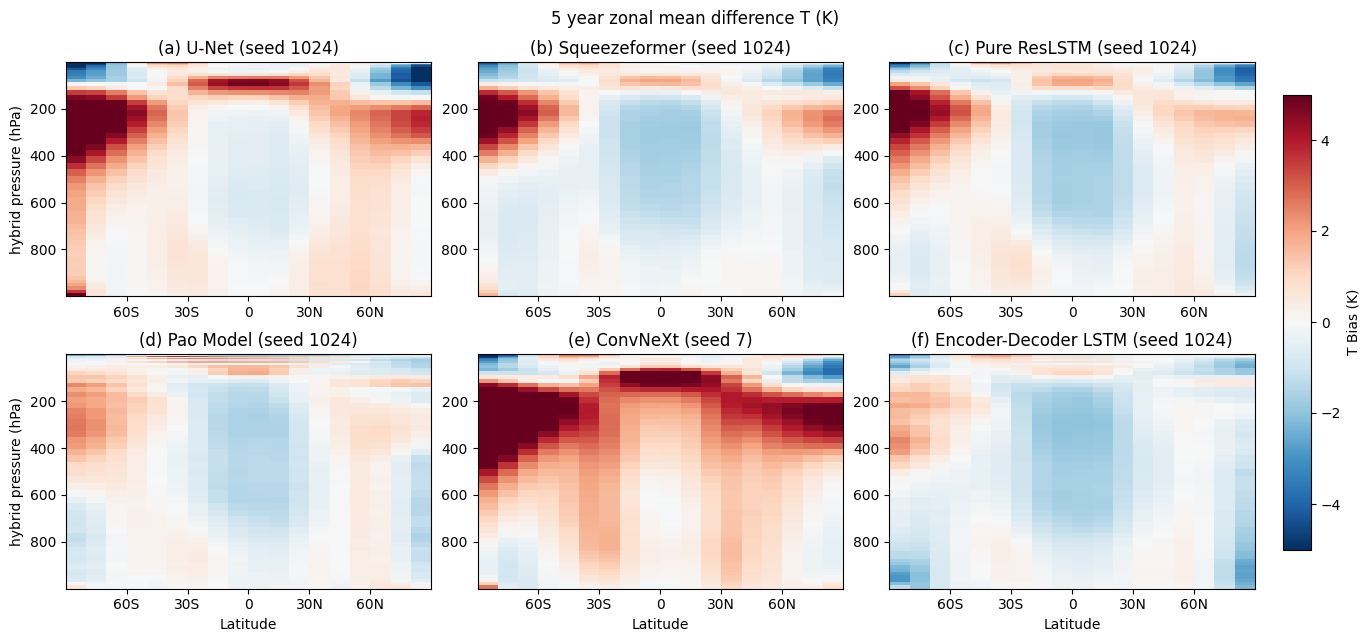

In [5]:
plot_zonal_mean_bias('T')

/tmp/ipykernel_2024237/2844692276.py:81: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


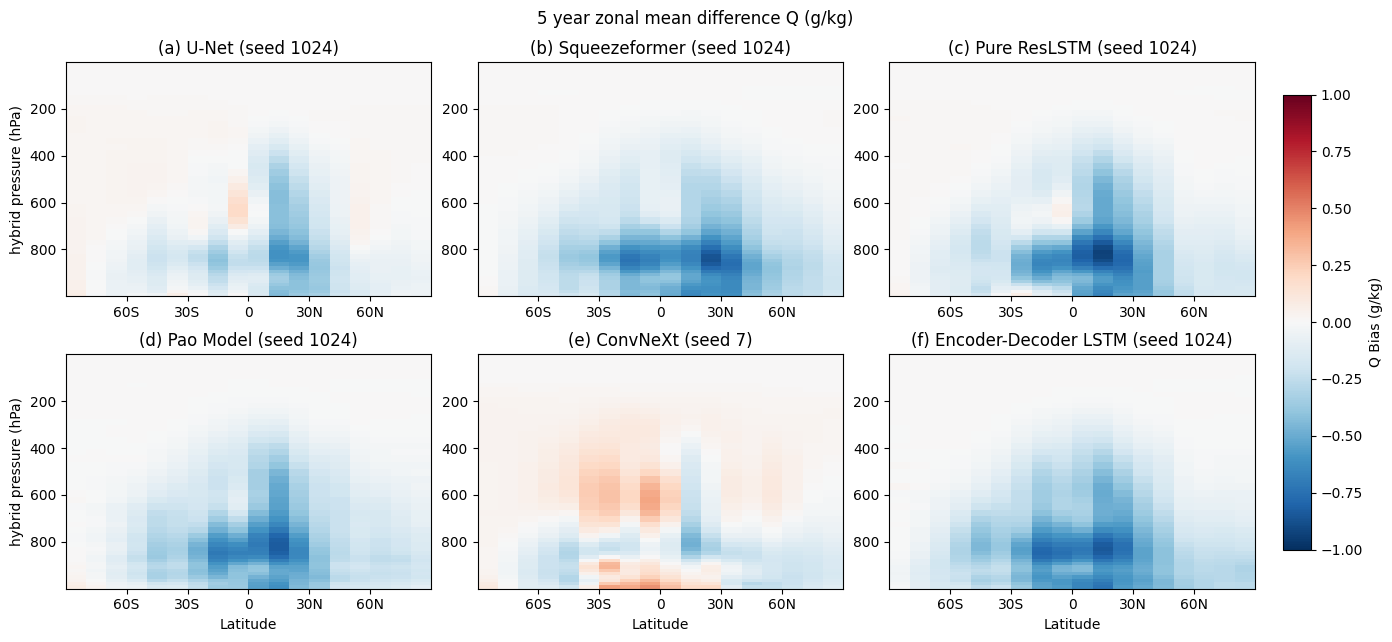

In [6]:
plot_zonal_mean_bias('Q')

/tmp/ipykernel_2024237/2844692276.py:81: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


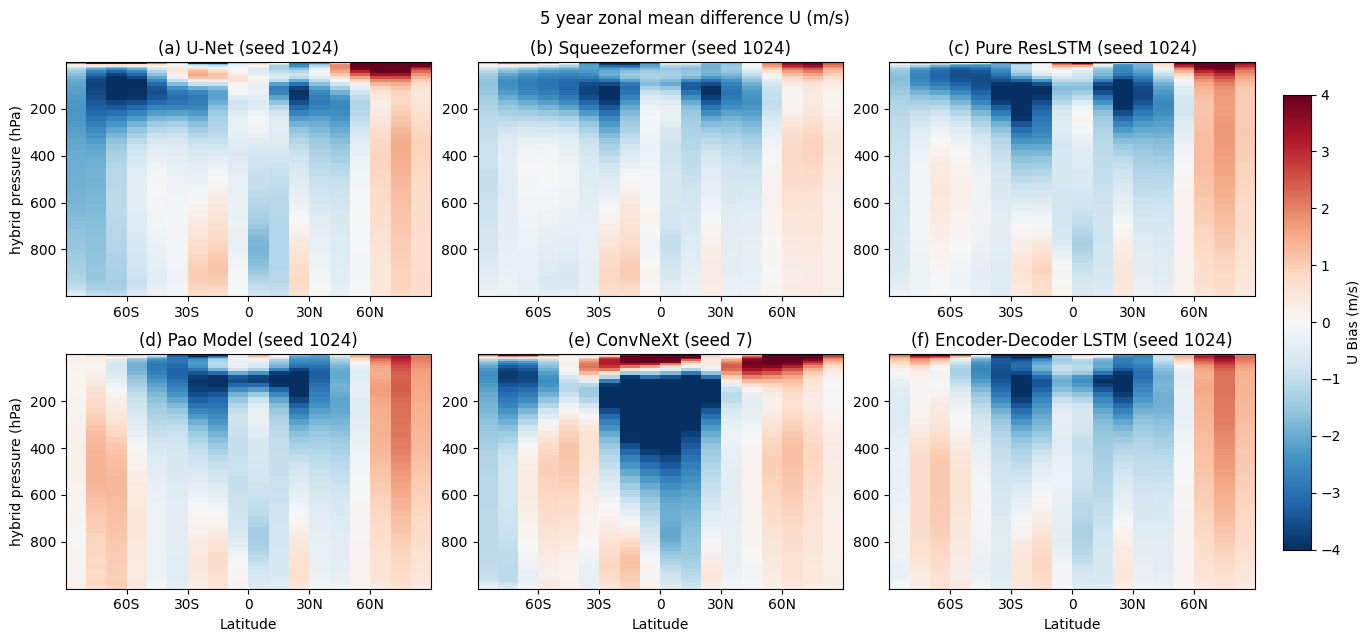

In [7]:
plot_zonal_mean_bias('U')

/tmp/ipykernel_2024237/2844692276.py:81: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


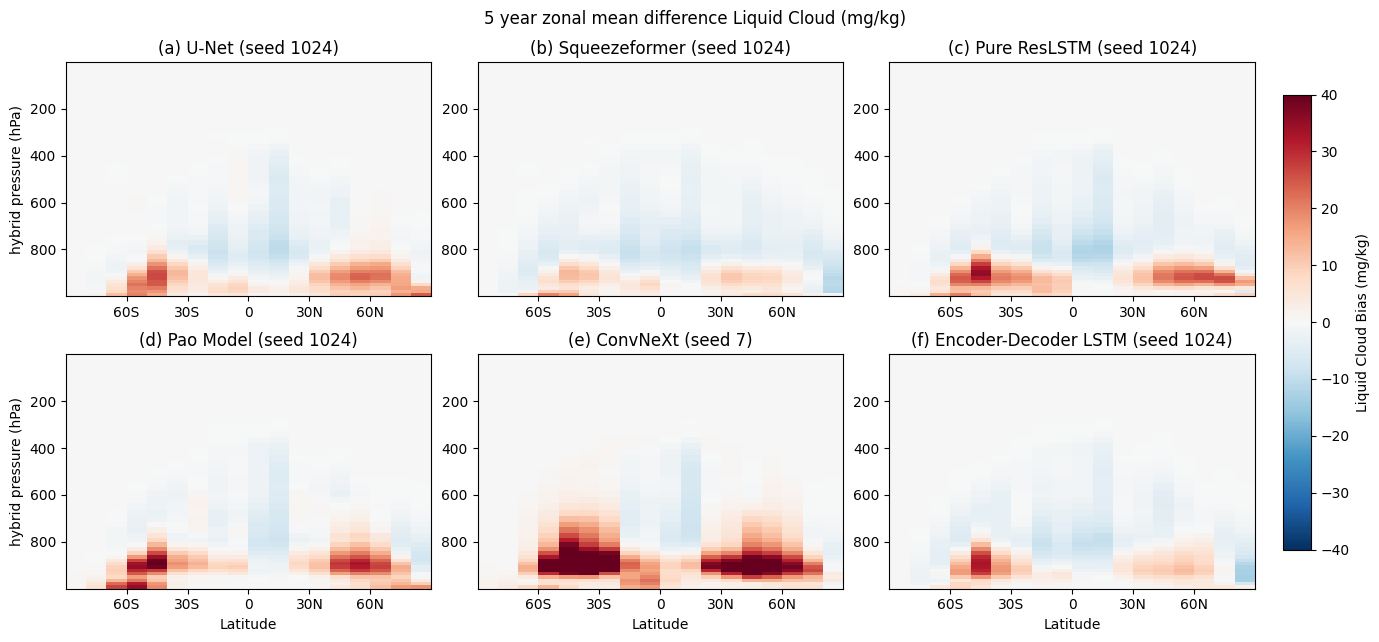

In [8]:
plot_zonal_mean_bias('CLDLIQ')

/tmp/ipykernel_2024237/2844692276.py:81: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


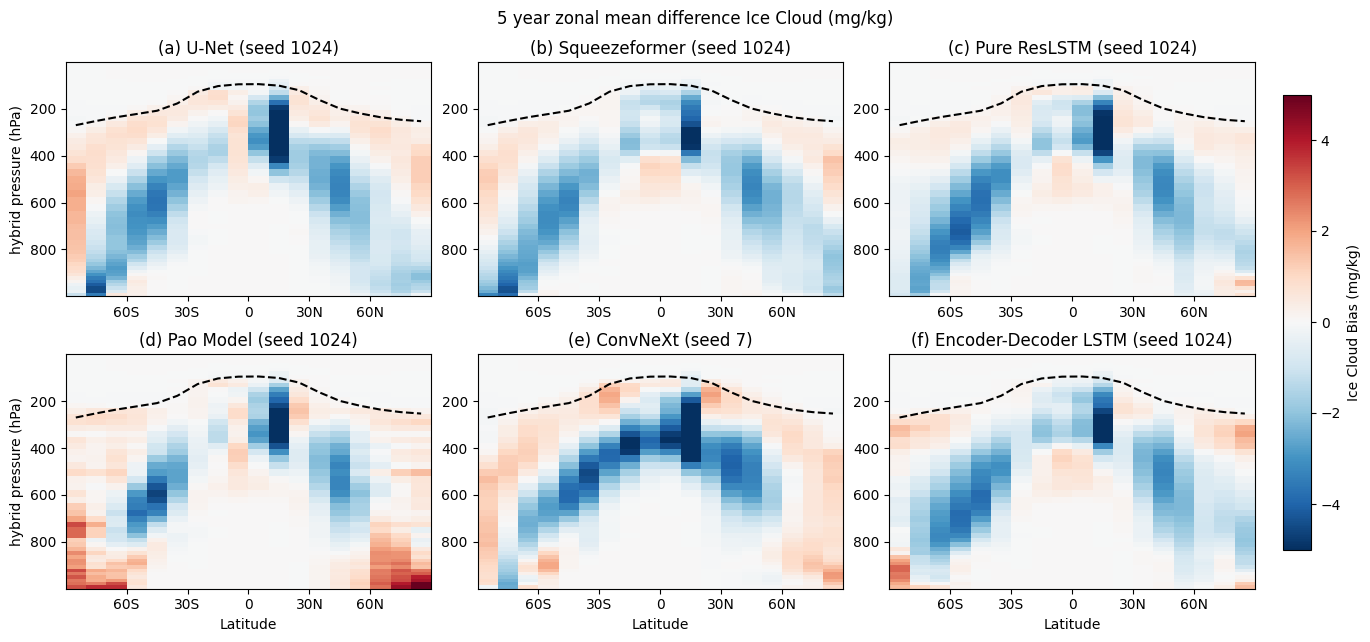

In [9]:
plot_zonal_mean_bias('CLDICE')

/tmp/ipykernel_2024237/2844692276.py:81: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


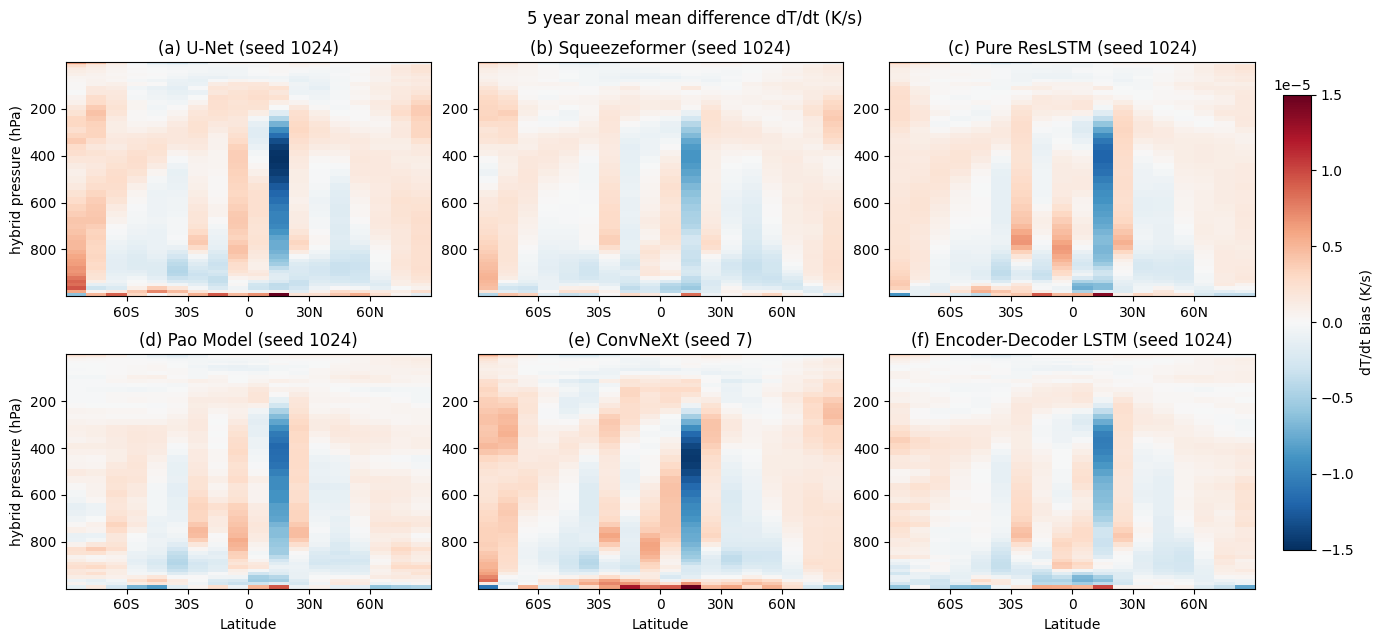

In [10]:
plot_zonal_mean_bias('DTPHYS')

/tmp/ipykernel_2024237/2844692276.py:81: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


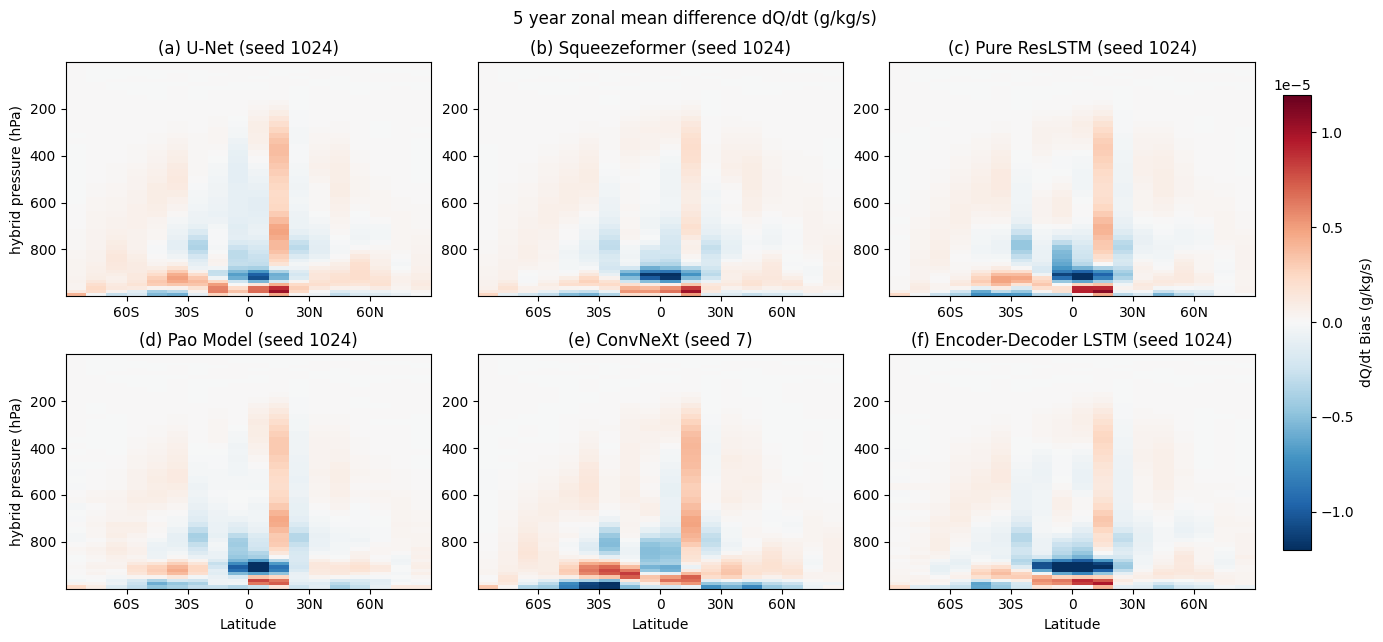

In [11]:
plot_zonal_mean_bias('DQ1PHYS')

/tmp/ipykernel_2024237/2844692276.py:81: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


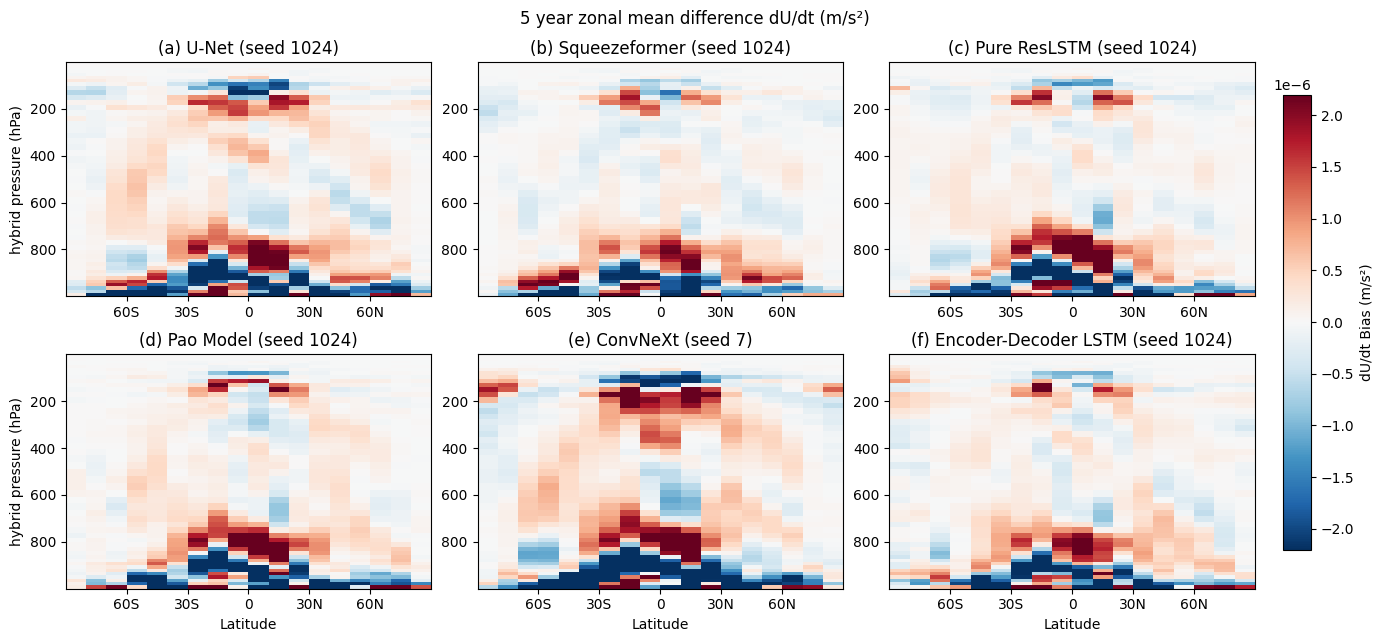

In [12]:
plot_zonal_mean_bias('DUPHYS')

/tmp/ipykernel_2024237/2844692276.py:81: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


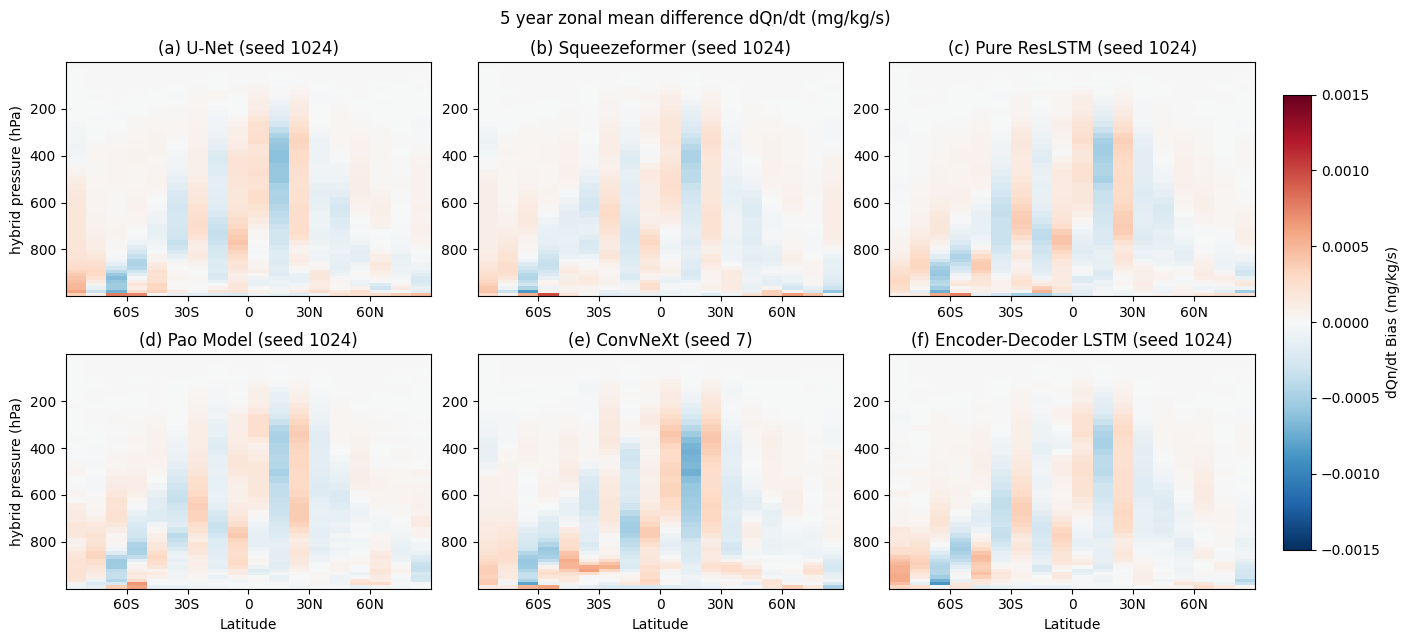

In [13]:
plot_zonal_mean_bias('DQnPHYS')

Text(0.5, 0.98, 'Five Year Online Root Mean Squared Error (Standard)')

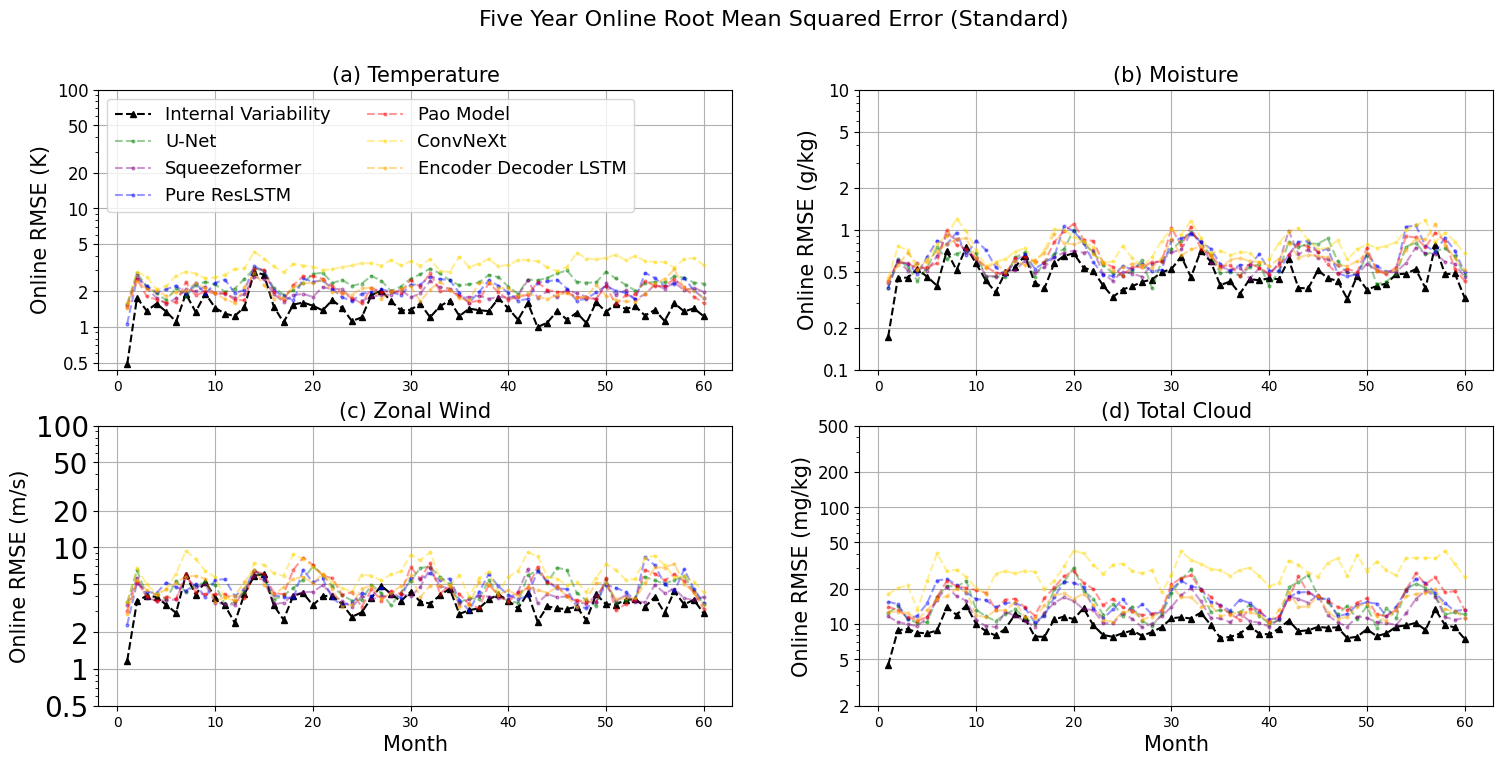

In [14]:
months = np.arange(1, 61)
def calculate_rmse(ds1, ds2, total_weight, var='T'):
    total_weight = get_dp(ds2) * ds2['area'].values[:,None,:]
    # Determine the number of months in ds1
    if var == 'qn':
        num_months = ds1['CLDLIQ'].shape[0]
    else:
        num_months = ds1[var].shape[0]
    
    # Slice total_weight to match the number of months in ds1
    total_weight_sliced = total_weight[:num_months, :, :]
    
    # Initialize the RMSE array with NaN values
    rmse_per_month = np.full(60, np.nan)
    
    # Compute RMSE for existing months
    if var == 'qn':
        squared_diff = (ds1['CLDLIQ'] + ds1['CLDICE'] - ds2['CLDLIQ'] - ds2['CLDICE'])**2
    else:
        squared_diff = (ds1[var] - ds2[var]) ** 2
    weighted_squared_diff = squared_diff * total_weight_sliced
    weighted_sum = weighted_squared_diff.sum(axis=(1, 2))
    total_weight_sum = total_weight_sliced.sum(axis=(1, 2))
    weighted_mean_squared_diff = weighted_sum / total_weight_sum
    rmse_existing_months = np.sqrt(weighted_mean_squared_diff)
    
    # Fill in the RMSE array with the computed values
    rmse_per_month[:num_months] = rmse_existing_months.values
    if var == 'Q':
        rmse_per_month = rmse_per_month * 1e3
    elif var == 'qn':
        rmse_per_month = rmse_per_month * 1e6
    return rmse_per_month


fig, axes = plt.subplots(2, 2, figsize=(18, 8))

axes[0,0].plot(months, calculate_rmse(ds_sp_2, ds_sp_1, total_weight, var='T'), label='Internal Variability', color='black', linestyle='--', marker='^', markersize = 4)
axes[0,0].plot(months, calculate_rmse(ds_unet_seed_1024, ds_sp_1, total_weight, var='T'), label = 'U-Net', color = 'green', linestyle='--', marker='o', alpha = .4, markersize = 2)
axes[0,0].plot(months, calculate_rmse(ds_squeezeformer_seed_1024, ds_sp_1, total_weight, var='T'), label = 'Squeezeformer', color = 'purple', linestyle='--', marker='o', alpha = .4, markersize = 2)
axes[0,0].plot(months, calculate_rmse(ds_pure_resLSTM_seed_1024, ds_sp_1, total_weight, var='T'), label = 'Pure ResLSTM', color = 'blue', linestyle='--', marker='o', alpha = .4, markersize = 2)
axes[0,0].plot(months, calculate_rmse(ds_pao_model_seed_1024, ds_sp_1, total_weight, var='T'), label = 'Pao Model', color = 'red', linestyle='--', marker='o', alpha = .4, markersize = 2)
axes[0,0].plot(months, calculate_rmse(ds_convnext_seed_7, ds_sp_1, total_weight, var='T'), label = 'ConvNeXt', color = 'gold', linestyle='--', marker='o', alpha = .4, markersize = 2)
axes[0,0].plot(months, calculate_rmse(ds_encdec_lstm_seed_1024, ds_sp_1, total_weight, var='T'), label = 'Encoder Decoder LSTM', color = 'orange', linestyle='--', marker='o', alpha = .4, markersize = 2)
axes[0,0].set_yscale('log')
axes[0,0].set_yticks([0.5, 1, 2, 5, 10, 20, 50, 100])
axes[0,0].set_yticklabels(['0.5', '1', '2', '5', '10', '20', '50', '100'], fontsize=12)
axes[0,0].set_ylabel('Online RMSE (K)', fontsize=15)
axes[0,0].set_title('(a) Temperature', fontsize=15)
axes[0,0].legend(fontsize=13, loc='upper left', ncol = 2)
axes[0,0].grid(True)

axes[0,1].plot(months, calculate_rmse(ds_sp_2, ds_sp_1, total_weight, var='Q'), label='Internal Variability', color='black', linestyle='--', marker='^', markersize = 4)
axes[0,1].plot(months, calculate_rmse(ds_unet_seed_1024, ds_sp_1, total_weight, var='Q'), label = 'U-Net', color = 'green', linestyle='--', marker='o', alpha = .4, markersize = 2)
axes[0,1].plot(months, calculate_rmse(ds_squeezeformer_seed_1024, ds_sp_1, total_weight, var='Q'), label = 'Squeezeformer', color = 'purple', linestyle='--', marker='o', alpha = .4, markersize = 2)
axes[0,1].plot(months, calculate_rmse(ds_pure_resLSTM_seed_1024, ds_sp_1, total_weight, var='Q'), label = 'Pure ResLSTM', color = 'blue', linestyle='--', marker='o', alpha = .4, markersize = 2)
axes[0,1].plot(months, calculate_rmse(ds_pao_model_seed_1024, ds_sp_1, total_weight, var='Q'), label = 'Pao Model', color = 'red', linestyle='--', marker='o', alpha = .4, markersize = 2)
axes[0,1].plot(months, calculate_rmse(ds_convnext_seed_7, ds_sp_1, total_weight, var='Q'), label = 'ConvNeXt', color = 'gold', linestyle='--', marker='o', alpha = .4, markersize = 2)
axes[0,1].plot(months, calculate_rmse(ds_encdec_lstm_seed_1024, ds_sp_1, total_weight, var='Q'), label = 'Encoder Decoder LSTM', color = 'orange', linestyle='--', marker='o', alpha = .4, markersize = 2)
axes[0,1].set_yscale('log')
axes[0,1].set_yticks([0.1, 0.2, 0.5, 1, 2, 5, 10])
axes[0,1].set_yticklabels(['0.1', '0.2', '0.5', '1', '2', '5', '10'], fontsize=12)
axes[0,1].set_ylabel('Online RMSE (g/kg)', fontsize=15)
axes[0,1].set_title('(b) Moisture', fontsize=15)
axes[0,1].grid(True)

axes[1,0].plot(months, calculate_rmse(ds_sp_2, ds_sp_1, total_weight, var='U'), label='Internal Variability', color='black', linestyle='--', marker='^', markersize = 4)
axes[1,0].plot(months, calculate_rmse(ds_unet_seed_1024, ds_sp_1, total_weight, var='U'), label = 'U-Net', color = 'green', linestyle='--', marker='o', alpha = .4, markersize = 2)
axes[1,0].plot(months, calculate_rmse(ds_squeezeformer_seed_1024, ds_sp_1, total_weight, var='U'), label = 'Squeezeformer', color = 'purple', linestyle='--', marker='o', alpha = .4, markersize = 2)
axes[1,0].plot(months, calculate_rmse(ds_pure_resLSTM_seed_1024, ds_sp_1, total_weight, var='U'), label = 'Pure ResLSTM', color = 'blue', linestyle='--', marker='o', alpha = .4, markersize = 2)
axes[1,0].plot(months, calculate_rmse(ds_pao_model_seed_1024, ds_sp_1, total_weight, var='U'), label = 'Pao Model', color = 'red', linestyle='--', marker='o', alpha = .4, markersize = 2)
axes[1,0].plot(months, calculate_rmse(ds_convnext_seed_7, ds_sp_1, total_weight, var='U'), label = 'ConvNeXt', color = 'gold', linestyle='--', marker='o', alpha = .4, markersize = 2)
axes[1,0].plot(months, calculate_rmse(ds_encdec_lstm_seed_1024, ds_sp_1, total_weight, var='U'), label = 'Encoder Decoder LSTM', color = 'orange', linestyle='--', marker='o', alpha = .4, markersize = 2)
axes[1,0].set_yscale('log')
axes[1,0].set_yticks([0.5, 1, 2, 5, 10, 20, 50, 100])
axes[1,0].set_yticklabels(['0.5', '1', '2', '5', '10', '20', '50', '100'], fontsize=20)
axes[1,0].set_ylabel('Online RMSE (m/s)', fontsize=15)
axes[1,0].set_title('(c) Zonal Wind', fontsize=15)
axes[1,0].grid(True)

axes[1,1].plot(months, calculate_rmse(ds_sp_2, ds_sp_1, total_weight, var='qn'), label='Internal Variability', color='black', linestyle='--', marker='^', markersize = 4)
axes[1,1].plot(months, calculate_rmse(ds_unet_seed_1024, ds_sp_1, total_weight, var='qn'), label = 'U-Net', color = 'green', linestyle='--', marker='o', alpha = .4, markersize = 2)
axes[1,1].plot(months, calculate_rmse(ds_squeezeformer_seed_1024, ds_sp_1, total_weight, var='qn'), label = 'Squeezeformer', color = 'purple', linestyle='--', marker='o', alpha = .4, markersize = 2)
axes[1,1].plot(months, calculate_rmse(ds_pure_resLSTM_seed_1024, ds_sp_1, total_weight, var='qn'), label = 'Pure ResLSTM', color = 'blue', linestyle='--', marker='o', alpha = .4, markersize = 2)
axes[1,1].plot(months, calculate_rmse(ds_pao_model_seed_1024, ds_sp_1, total_weight, var='qn'), label = 'Pao Model', color = 'red', linestyle='--', marker='o', alpha = .4, markersize = 2)
axes[1,1].plot(months, calculate_rmse(ds_convnext_seed_7, ds_sp_1, total_weight, var='qn'), label = 'ConvNeXt', color = 'gold', linestyle='--', marker='o', alpha = .4, markersize = 2)
axes[1,1].plot(months, calculate_rmse(ds_encdec_lstm_seed_1024, ds_sp_1, total_weight, var='qn'), label = 'Encoder Decoder LSTM', color = 'orange', linestyle='--', marker='o', alpha = .4, markersize = 2)
axes[1,1].set_yscale('log')
axes[1,1].set_yticks([2, 5, 10, 20, 50, 100, 200, 500])
axes[1,1].set_yticklabels(['2', '5', '10', '20', '50', '100', '200', '500'], fontsize=12)
axes[1,1].set_ylabel('Online RMSE (mg/kg)', fontsize=15)
axes[1,1].set_title('(d) Total Cloud', fontsize=15)
axes[1,1].grid(True)

axes[1,0].set_xlabel('Month', fontsize=15)
axes[1,1].set_xlabel('Month', fontsize=15)

fig.suptitle('Five Year Online Root Mean Squared Error (Standard)', fontsize = 16)

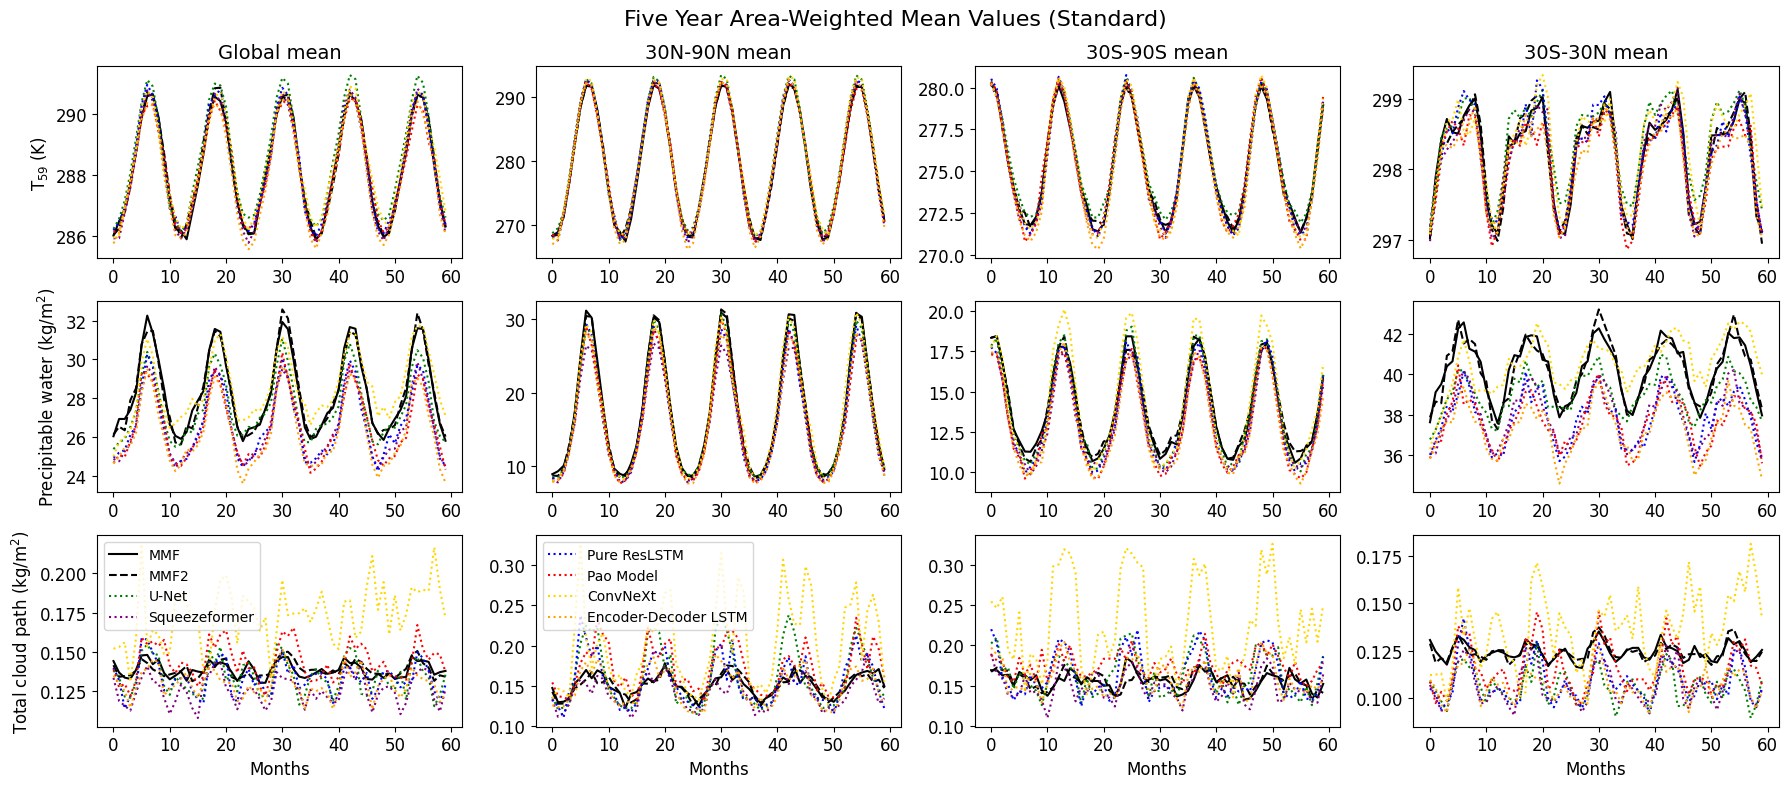

In [17]:
xtime = np.arange(60)

area_weight_nh = np.where(lat > 30, area_weight, 0)
area_weight_sh = np.where(lat < -30, area_weight, 0)
area_weight_tropics = np.where((lat > - 30) & (lat < 30), area_weight, 0)

# Titles for columns
column_titles = ['Global mean', '30N-90N mean', '30S-90S mean', '30S-30N mean']

# Y-axis labels for rows
row_ylabels = [
    'T$_{59}$ (K)',
    'Precipitable water (kg/m$^2$)',
    'Total cloud path (kg/m$^2$)'
]

# Define area weights
weights = ['area_weight', 'area_weight_nh', 'area_weight_sh', 'area_weight_tropics']
weights_dict = {
    'area_weight': area_weight,
    'area_weight_nh': area_weight_nh,
    'area_weight_sh': area_weight_sh,
    'area_weight_tropics': area_weight_tropics,
}

# Define variables and associated averaging functions
variables = ['T', 'TMQ', 'TCP']
get_mean_function = {
    'T': lambda ds, w: np.average(ds['T'][:, -1, :].values, weights=w, axis=1),
    'TMQ': lambda ds, w: np.average(ds['TMQ'][:, :].values, weights=w, axis=1),
    'TCP': lambda ds, w: get_tcp_mean(ds, w)
}

# Create a figure with 3 rows and 4 columns
fig, axes = plt.subplots(3, 4, figsize=(18, 8))

# Generate subplots
for row, var in enumerate(variables):
    for col, weight_key in enumerate(weights):
        weight = weights_dict[weight_key]
        ds_sp_1_mean = get_mean_function[var](ds_sp_1, weight)
        ds_sp_2_mean = get_mean_function[var](ds_sp_2, weight)
        unet_seed_1024_mean = get_mean_function[var](ds_unet_seed_1024, weight)
        squeezeformer_seed_1024_mean = get_mean_function[var](ds_squeezeformer_seed_1024, weight)
        pure_resLSTM_seed_1024_mean = get_mean_function[var](ds_pure_resLSTM_seed_1024, weight)
        pao_model_seed_1024_mean = get_mean_function[var](ds_pao_model_seed_1024, weight)
        convnext_seed_7_mean = get_mean_function[var](ds_convnext_seed_7, weight)
        encdec_lstm_seed_1024_mean = get_mean_function[var](ds_encdec_lstm_seed_1024, weight)
        
        line_mmf, = axes[row, col].plot(xtime, ds_sp_1_mean, label='MMF', color='black')
        line_mmf2, = axes[row, col].plot(xtime, ds_sp_2_mean, label='MMF2', color='black', linestyle = 'dashed')
        line_unet, = axes[row, col].plot(xtime, unet_seed_1024_mean, label='U-Net', color='green', linestyle = ':')
        line_squeezeformer, = axes[row, col].plot(xtime, squeezeformer_seed_1024_mean, label='Squeezeformer', color='purple', linestyle = ':')
        line_pure_resLSTM, = axes[row, col].plot(xtime, pure_resLSTM_seed_1024_mean, label='Pure ResLSTM', color='blue', linestyle = ':')
        line_pao_model, = axes[row, col].plot(xtime, pao_model_seed_1024_mean, label='Pao Model', color='red', linestyle = ':')
        line_convnext, = axes[row, col].plot(xtime, convnext_seed_7_mean, label='ConvNeXt', color='gold', linestyle = ':')
        line_encdec_lstm, = axes[row, col].plot(xtime, encdec_lstm_seed_1024_mean, label='Encoder-Decoder LSTM', color='orange', linestyle = ':')

        axes[row, col].tick_params(axis='both', labelsize=12) 
        # Set column titles
        if row == 0:
            axes[row, col].set_title(column_titles[col],fontsize=14)
        
        # Set row y-labels
        if col == 0:
            axes[row, col].set_ylabel(row_ylabels[row],fontsize=12)
        
        # Set x-label for the last row
        if row == 2:
            axes[row, col].set_xlabel("Months",fontsize=12)
        
        # Add legend to the first row, last column
        if row == 2 and col == 0:
            axes[row, col].legend(handles = [line_mmf, line_mmf2, line_unet, line_squeezeformer],
                                  labels = ['MMF', 'MMF2', 'U-Net', 'Squeezeformer'], fontsize=10,loc='upper left')
        elif row == 2 and col == 1:
            axes[row, col].legend(handles = [line_pure_resLSTM, line_pao_model, line_convnext, line_encdec_lstm],
                                  labels = ['Pure ResLSTM', 'Pao Model', 'ConvNeXt', 'Encoder-Decoder LSTM'], fontsize=10,loc='upper left')

fig.suptitle('Five Year Area-Weighted Mean Values (Standard)', fontsize = 16)
# Adjust layout and display the plot
plt.tight_layout()
# plt.savefig('time_series_mean_5years.pdf', format='pdf', dpi=400, bbox_inches='tight')
plt.show()

/tmp/ipykernel_349973/1338493742.py:71: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


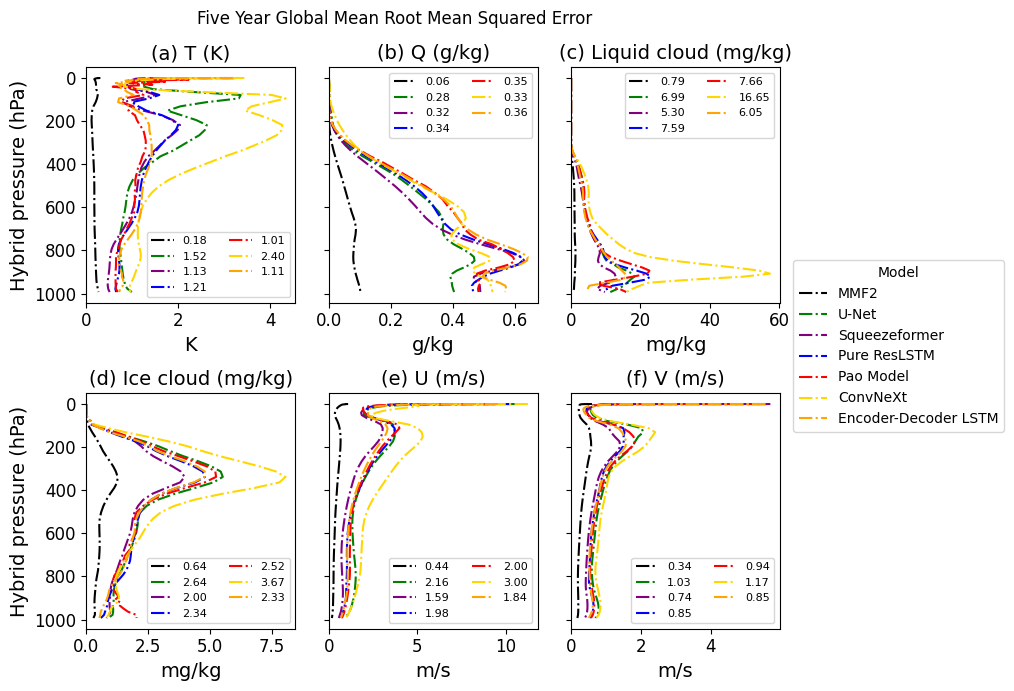

In [18]:
variables = ['T', 'Q', 'CLDLIQ', 'CLDICE', 'U', 'V']
scaling_dict = {'T': 1.0, 'Q': 1000.0, 'CLDLIQ': 1e6, 'CLDICE': 1e6, 'U': 1.0, 'V': 1.0}  # Scaling factors
units_dict = {'T': 'K', 'Q': 'g/kg', 'CLDLIQ': 'mg/kg', 'CLDICE': 'mg/kg', 'U': 'm/s', 'V': 'm/s'}  # Units
titles = [
    '(a) T',
    '(b) Q',
    '(c) Liquid cloud',
    '(d) Ice cloud',
    '(e) U',
    '(f) V',
]  # Main titles with subplot labels

fig, axes = plt.subplots(2, 3, figsize=(8, 7), sharey=True, constrained_layout=True)  # 2 rows, 3 columns
axes = axes.flatten()  # Flatten axes for easier iteration

for ax, var, title in zip(axes, variables, titles):
    # Use specified scaling for the variable
    scaling = scaling_dict[var]

    # Compute time-mean and RMSE for each variable
    ds_sp_1_mean = ds_sp_1[var].mean(dim = 'time').values * scaling
    ds_sp_2_mean = ds_sp_2[var].mean(dim = 'time').values * scaling
    ds_unet_mean = ds_unet_seed_1024[var].mean(dim = 'time').values * scaling
    ds_squeezeformer_mean = ds_squeezeformer_seed_1024[var].mean(dim = 'time').values * scaling
    ds_pure_resLSTM_mean = ds_pure_resLSTM_seed_1024[var].mean(dim = 'time').values * scaling
    ds_pao_model_mean = ds_pao_model_seed_1024[var].mean(dim = 'time').values * scaling
    ds_convnext_mean = ds_convnext_seed_7[var].mean(dim = 'time').values * scaling
    ds_encdec_lstm_mean = ds_encdec_lstm_seed_1024[var].mean(dim = 'time').values * scaling

    mmf_rmse = np.sqrt(np.average((ds_sp_2_mean - ds_sp_1_mean) ** 2, axis = 1, weights = area_weight))
    unet_rmse = np.sqrt(np.average((ds_unet_mean - ds_sp_1_mean) ** 2, axis = 1, weights = area_weight))
    squeezeformer_rmse = np.sqrt(np.average((ds_squeezeformer_mean - ds_sp_1_mean) ** 2, axis = 1, weights = area_weight))
    pure_resLSTM_rmse = np.sqrt(np.average((ds_pure_resLSTM_mean - ds_sp_1_mean) ** 2, axis = 1, weights = area_weight))
    pao_model_rmse = np.sqrt(np.average((ds_pao_model_mean - ds_sp_1_mean) ** 2, axis = 1, weights = area_weight))
    convnext_rmse = np.sqrt(np.average((ds_convnext_mean - ds_sp_1_mean) ** 2, axis = 1, weights = area_weight))
    encdec_lstm_rmse = np.sqrt(np.average((ds_encdec_lstm_mean - ds_sp_1_mean) ** 2, axis = 1, weights = area_weight))

    mmf_rmse_global = np.sqrt(np.average((ds_sp_2_mean - ds_sp_1_mean) ** 2, weights = total_weight))
    unet_rmse_global = np.sqrt(np.average((ds_unet_mean - ds_sp_1_mean) ** 2, weights = total_weight))
    squeezeformer_rmse_global = np.sqrt(np.average((ds_squeezeformer_mean - ds_sp_1_mean) ** 2, weights = total_weight))
    pure_resLSTM_rmse_global = np.sqrt(np.average((ds_pure_resLSTM_mean - ds_sp_1_mean) ** 2, weights = total_weight))
    pao_model_rmse_global = np.sqrt(np.average((ds_pao_model_mean - ds_sp_1_mean) ** 2, weights = total_weight))
    convnext_rmse_global = np.sqrt(np.average((ds_convnext_mean - ds_sp_1_mean) ** 2, weights = total_weight))
    encdec_lstm_rmse_global = np.sqrt(np.average((ds_encdec_lstm_mean - ds_sp_1_mean) ** 2, weights = total_weight))

    # Plot on the corresponding axis
    line_mmf, = ax.plot(mmf_rmse, lev, label=f'{mmf_rmse_global:.2f}', linestyle='-.', color='black')
    line_unet, = ax.plot(unet_rmse, lev, label=f'{unet_rmse_global:.2f}', color='green', linestyle = '-.')
    line_squeezeformer, = ax.plot(squeezeformer_rmse, lev, label=f'{squeezeformer_rmse_global:.2f}', color='purple', linestyle = '-.')
    line_pure_resLSTM, = ax.plot(pure_resLSTM_rmse, lev, label=f'{pure_resLSTM_rmse_global:.2f}', color='blue', linestyle = '-.')
    line_pao_model, = ax.plot(pao_model_rmse, lev, label=f'{pao_model_rmse_global:.2f}', color='red', linestyle = '-.')
    line_convnext, = ax.plot(convnext_rmse, lev, label=f'{convnext_rmse_global:.2f}', color='gold', linestyle = '-.')
    line_encdec_lstm, = ax.plot(encdec_lstm_rmse, lev, label=f'{encdec_lstm_rmse_global:.2f}', color='orange', linestyle = '-.')
    
    ax.set_xlim(left=0)
    ax.tick_params(axis='both', labelsize=12)
    ax.set_title(title+f' ({units_dict[var]})', fontsize=14, loc='center')  # Add main title with subplot label
    ax.set_xlabel(f'{units_dict[var]}', fontsize=14)  # Keep unit in x-label
    ax.invert_yaxis()  # Reverse the y-axis
    ax.legend(fontsize=8, ncol = 2)

handles = [line_mmf, line_unet, line_squeezeformer, line_pure_resLSTM, line_pao_model, line_convnext, line_encdec_lstm]
labels = ['MMF2', 'U-Net', 'Squeezeformer', 'Pure ResLSTM', 'Pao Model', 'ConvNeXt', 'Encoder-Decoder LSTM']

fig.legend(handles, labels, loc='center right', bbox_to_anchor=(1.27, 0.5), title='Model')
fig.suptitle('Five Year Global Mean Root Mean Squared Error')
# Set a shared y-label for the first column
axes[0].set_ylabel('Hybrid pressure (hPa)', fontsize=14)
axes[3].set_ylabel('Hybrid pressure (hPa)', fontsize=14)
plt.gca().invert_yaxis() 
plt.tight_layout()
# plt.savefig('state_rmse_profiles_and_scalar.pdf', format='pdf', dpi=400, bbox_inches='tight')
plt.show()